In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [3]:
#series = TimeSeries.from_csv("https://data.ecoforecast.org/targets/aquatics/aquatics-targets.csv.gz", time_col = "time")

aquatics = pd.read_csv("https://data.ecoforecast.org/targets/aquatics/aquatics-targets.csv.gz") 
aquatics


,time,siteID,oxygen,temperature,chla,oxygen_sd,temperature_sd,chla_sd,depth_oxygen,depth_temperature
0,2017-08-27,BARC,NaN,31.449792,NaN,NaN,0.001621,NaN,NaN,0.05
1,2017-08-27,BARC,NaN,31.478542,NaN,NaN,0.001209,NaN,NaN,0.55
2,2017-08-28,BARC,NaN,31.086667,NaN,NaN,0.001549,NaN,NaN,0.05
3,2017-08-28,BARC,NaN,31.112917,NaN,NaN,0.001170,NaN,NaN,0.55
4,2017-08-29,BARC,NaN,31.159167,NaN,NaN,0.002114,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...
9758,2020-11-16,BARC,NaN,24.490208,NaN,NaN,0.001332,NaN,NaN,0.55
9759,2020-11-17,BARC,NaN,23.886042,NaN,NaN,0.001296,NaN,NaN,0.05
9760,2020-11-17,BARC,NaN,23.876458,NaN,NaN,0.001137,NaN,NaN,0.55
9761,2021-09-14,MCDI,NaN,19.031106,NaN,NaN,0.021150,NaN,NaN,NaN


In [4]:

 temp = aquatics.query("siteID == 'BARC'").query("depth_temperature == 0.55").filter(items=['time', 'temperature', 'depth_temperature'])

 # consider siteID, depth variables as "future covariates", 


In [5]:

series = TimeSeries.from_dataframe(temp, time_col = 'time', value_cols='temperature', fill_missing_dates=True, freq='D')

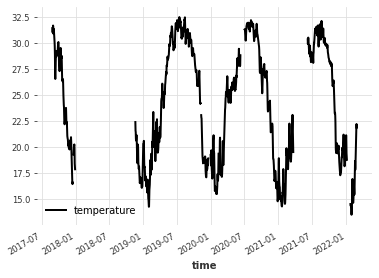

In [6]:

series.plot()

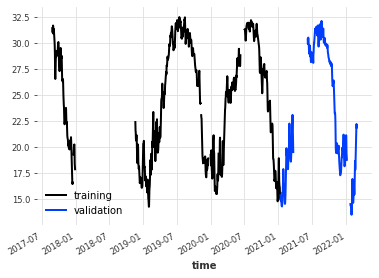

In [7]:
train, val = series.split_before(0.75)
train.plot(label="training")
val.plot(label="validation")


In [8]:
horizon = val.n_timesteps
pts_in_yr = 400

/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


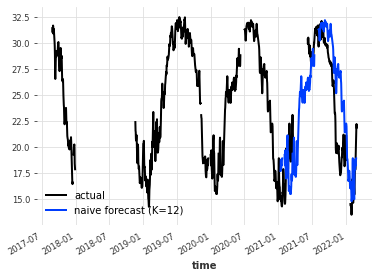

In [9]:
from darts.models import NaiveSeasonal

seasonal_model = NaiveSeasonal(K=pts_in_yr)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(horizon)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")



# Probablistic Forecasts

/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


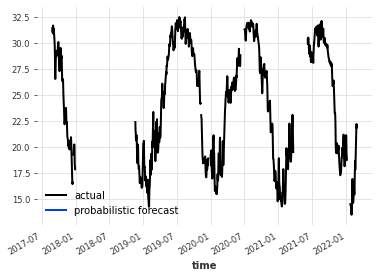

In [10]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta
model_es = ExponentialSmoothing()
model_es.fit(train)
probabilistic_forecast = model_es.predict(len(val), num_samples=500)

series.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()



Missing values will create a problem for the neural net.  We infer them first:

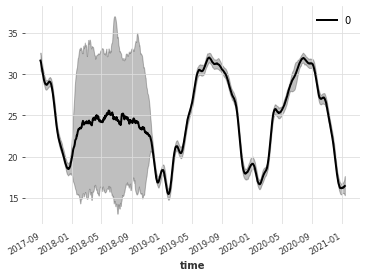

In [11]:
from darts.models import GaussianProcessFilter
from sklearn.gaussian_process.kernels import RBF


kernel = RBF()

gpf = GaussianProcessFilter(kernel=kernel, alpha=0.1, normalize_y=True)
filtered_series = gpf.filter(train, num_samples=100)

filtered_series.plot()



In [12]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood


model = TCNModel(
    input_chunk_length=400,
    output_chunk_length=100,
    random_state=42,
    likelihood=LaplaceLikelihood(),
    torch_device_str = "cuda"
)
model.trainer_params


[2022-04-05 22:46:51,856] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags
[2022-04-05 22:46:51,856] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: `torch_device_str` is deprecated and will be removed in a coming Darts version. For full support of all torch devices, use PyTorch-Lightnings trainer flags and pass them inside `pl_trainer_kwargs`. Flags of interest are {`accelerator`, `gpus`, `auto_select_gpus`, `devices`}. For more information, visit https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags


{'accelerator': 'gpu',
 'gpus': -1,
 'auto_select_gpus': True,
 'logger': False,
 'max_epochs': 100,
 'check_val_every_n_epoch': 1,
 'enable_checkpointing': False,
 'callbacks': []}

In [13]:

from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
train_scaled = scaler.fit_transform(filtered_series)


In [14]:
model.fit(train_scaled, epochs=400, verbose=True)

[2022-04-05 22:46:52,163] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-05 22:46:52,163] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 735 samples.
[2022-04-05 22:46:52,187] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-04-05 22:46:52,187] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-04-05 22:46:52,190] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-05 22:46:52,190] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-04-05 22:46:52,190] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightning Trainer parameters `enable_progress_bar`, `progr

Epoch 399: 100%|██████████| 23/23 [01:56<00:00,  5.06s/it, loss=-0.966, train_loss=-1.02] 


In [15]:
pred = model.predict(n=horizon, num_samples=500)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, -187.66it/s]


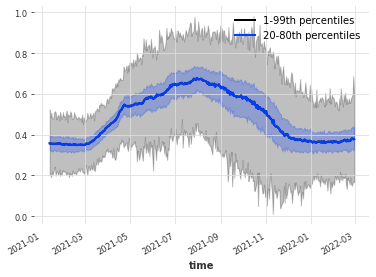

In [16]:

pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")

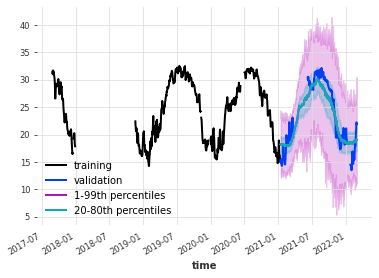

In [17]:
train.plot(label="training")
val.plot(label="validation")
pred = scaler.inverse_transform(pred)
pred.plot(low_quantile=0.01, high_quantile=0.99, label="1-99th percentiles")
pred.plot(low_quantile=0.2, high_quantile=0.8, label="20-80th percentiles")


In [18]:
# some methods for darts.Timeseries: Observe:
pred.is_stochastic # True
pred.n_components # 1
pred.n_samples # 500

#pred.with_columns_renamed("component", "temperature")


500

Now we would like to serialize our forecast to a standard EFI format (time, site_id, variable, value, ensemble)



In [40]:

nd = pred.all_values() # numpy nd-array
nd.shape # time x variables x replicates
# index the first variable
var1 = nd[:,0,:]
var1.shape # time x replicate -- 2D array can be converted to DataFrame

(413, 500)

In [ ]:

df = pd.DataFrame(var1)
df['time'] = pred.time_index
# pivot longer, ensemble as id, not as column name
df = df.melt(id_vars="time", var_name="ensemble", value_name="value")

df['variable'] = "temperature"
df['site_id'] = "BART"

df.to_csv("TCN_aquatics.csv.gz")
df

In [ ]:

## fun with xarray
da = pred.data_array() # underlying xarray object
da = da.assign_coords({"time": pred.time_index})

da = da.assign_coords({"site_id": "BARC"}) # text-valued coordinates!
da = da.rename({"sample": "ensemble"})
da = da.rename({"component": "variable"})
#da.variable.attrs["long name"] = "lake surface temperature"
#da.variable.attrs["units"] = "degrees C"
da.attrs["long name"] = "Forecast of temperature levels at BARC site using a ML-based prediction"


da = da.assign_coords({"time": pred.time_index})


da

<xarray.DataArray (time: 413, variable: 1, ensemble: 500)>
array([[[23.55347633, 14.5034333 , 19.40906167, ..., 18.13796484,
         19.30958436, 18.15082882]],

       [[19.69001262, 17.63138795, 15.12667856, ..., 16.8883141 ,
         19.74193589, 16.35898209]],

       [[17.5600296 , 17.79312946, 22.72233155, ..., 21.32531379,
         18.04493231, 18.50203021]],

       ...,

       [[18.12247278, 19.55923116, 18.58943446, ..., 21.88143794,
         19.53954397, 21.85809178]],

       [[19.26934339, 19.97628724, 20.90491407, ..., 22.7602772 ,
         16.91288635, 22.96117928]],

       [[17.51137307, 20.18388115, 20.33956277, ..., 13.52917454,
         21.6285382 , 21.71346777]]])
Coordinates:
  * time      (time) datetime64[ns] 2021-01-12 2021-01-13 ... 2022-02-28
  * variable  (variable) object '0'
    site_id   <U4 'BARC'
Dimensions without coordinates: ensemble
Attributes:
    long name:  Forecast of temperature levels at BARC site using a ML-based ...

In [ ]:
#import xarray as xr
#template = xr.DataArray(da.values, coords = {
#    "time": da.time,
#    "variable": ["temperature"],
#    "ensemble": range(500)
#    })
#da.reindex_like(template)

## Same as this: creates NaN
## da.reindex({"variable": ["temperature"]})

#da.set_index(temperature=["variable"])


In [ ]:

da.to_netcdf("test.ncdf")
## cannot go to pandas / csv / tabular

#pred.add_datetime_attribute
#pred.quantiles_df().to_csv("TCN_aquatics.csv")

# Multi-dimensional analysis

In [ ]:
# Cannot have repeated time indices, divide into unique series

# average over repeated depth measurements on same day at same site?
temp_POSE  = aquatics.query("siteID == 'POSE'").filter(items=['time', 'temperature', 'depth_temperature'])
oxygen_POSE  = aquatics.query("siteID == 'POSE'").filter(items=['time', 'oxygen', 'depth_oxygen'])
temp_POSE
series_tP = TimeSeries.from_dataframe(temp_POSE, time_col = 'time', value_cols='temperature', fill_missing_dates=True, freq='D')
series_oP = TimeSeries.from_dataframe(oxygen_POSE, time_col = 'time', value_cols='oxygen', fill_missing_dates=True, freq='D')


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
xr.load_dataset("neon.grib", engine="cfgrib")

skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 591, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=2.0) new_value=Variable(dimensions=(), data=10.0)
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/home/cboettig/cboettig/forecasts-darts-framework/venv/lib/python3.8/site-packages/cfgrib/dataset.py", li

<xarray.Dataset>
Dimensions:            (latitude: 111, longitude: 183)
Coordinates:
    number             int64 0
    time               datetime64[ns] 2022-03-20
    step               timedelta64[ns] 00:00:00
    surface            float64 0.0
  * latitude           (latitude) float64 17.0 17.5 18.0 18.5 ... 71.0 71.5 72.0
  * longitude          (longitude) float64 203.0 203.5 204.0 ... 293.5 294.0
    valid_time         datetime64[ns] 2022-03-20
    heightAboveGround  float64 2.0
Data variables:
    sp                 (latitude, longitude) float32 1.015e+05 ... 1.018e+05
    t2m                (latitude, longitude) float32 297.9 297.9 ... 245.5 245.5
    r2                 (latitude, longitude) float32 76.75 76.35 ... 99.95 99.95
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          2
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2022-03-31T01:33 GRIB to CDM+CF via cfgrib-0.9.1...